In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math
import time
import os
import cv2
import datetime
import tensorflow as tf
import random as rd
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

/home/yuntao/anaconda3/envs/learn/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '
Using TensorFlow backend.


In [64]:
train_x = None
train_y = None
n_sample = 0

In [2]:
swipe_x1, swipe_y1, swipe_x2, swipe_y2 = 320, 1000, 320, 1000
mistrust = 1

In [3]:
def get_img():
    os.system('adb shell screencap -p /sdcard/1.png')
    os.system('adb pull /sdcard/1.png .')
    img = cv2.imread('1.png')
    img = img[::7,::7,1].reshape(1,183,103,1)
    return img

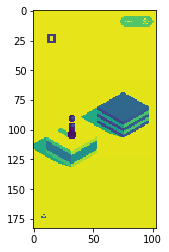

(183, 103, 1)
(183, 103)


In [4]:
img = get_img()
im = plt.imshow(img.reshape(183,103))
plt.show()
input_shape = img.shape[1:]
img_dim = img.shape[1:3]
print(input_shape)
print(img_dim)

In [5]:
img

array([[[[247],
         [247],
         [247],
         ..., 
         [247],
         [247],
         [247]],

        [[247],
         [247],
         [247],
         ..., 
         [247],
         [247],
         [247]],

        [[247],
         [247],
         [247],
         ..., 
         [247],
         [247],
         [247]],

        ..., 
        [[245],
         [245],
         [245],
         ..., 
         [245],
         [245],
         [245]],

        [[245],
         [245],
         [245],
         ..., 
         [245],
         [245],
         [245]],

        [[245],
         [245],
         [245],
         ..., 
         [245],
         [245],
         [245]]]], dtype=uint8)

In [6]:
np.amax(img[:50,:50])

255

In [7]:
def jump(press_time):
    cmd = 'adb shell input swipe {} {} {} {} {}'.format(swipe_x1, swipe_y1, swipe_x2, swipe_y2, math.ceil(max(press_time,200)))
    os.system(cmd)
    print(press_time)

In [8]:
def success(img_new,img):
    if np.amax(np.absolute(img_new.reshape(img_dim)[:25,:25]-img.reshape(img_dim)[:25,:25]))>50:
        return True
    else:
        return False

In [9]:
def fail(img_new):
    if np.amax(img_new.reshape(img_dim)[:25,:25])>50:
        return False
    else:
        return True

In [10]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='relu'))

model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adadelta())

In [31]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='relu'))

model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam())

In [11]:
def network(model,img,confidence):
    if rd.uniform(0,1)<confidence:
        return model.predict(img)
    else:
        return np.array(rd.randint(40,90)).reshape(1,1)

In [12]:
np.array(rd.randint(20,120)).reshape(1,1)[0][0]

69

In [12]:
mistrust = 1

In [13]:
def train(model,img,press_time):
    model.fit(img,np.array([press_time]).reshape(1,1),1)

In [14]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [17]:
def test():
    img = get_img()
    while(True):
        press_time = network(model,img,1)[0][0]
        jump(press_time*10)
        time.sleep(2.3+press_time/200)
        img_new = get_img()
        if fail(img_new):
            jump(2)
            time.sleep(0.8)
            img_new = get_img()
        img = img_new

In [23]:
train_x = np.load("train_x.npy")
train_y = np.load("train_y.npy")
n_sample = train_x.shape[0]

In [ ]:
img = get_img()
while(True):
    mistrust = mistrust*0.99
    press_time = network(model,img,1-mistrust)[0][0]
    jump(press_time*10)
    time.sleep(2.3+press_time/200)
    img_new = get_img()
    if fail(img_new):
        jump(2)
        time.sleep(0.8)
        img_new = get_img()
    elif success(img_new,img):
        if n_sample == 0:
            train_x = img
            train_y = press_time.reshape(1,1)
        else:
            train_x = np.concatenate((train_x,img),axis=0)
            train_y = np.concatenate((train_y,press_time.reshape(1,1)),axis=0)
        n_sample+=1
        if n_sample%128==0:
            mistrust = 1
            print(mistrust)
            model.fit(train_x,train_y)
            np.save('train_x',train_x)
            np.save('train_y',train_y)
    img = img_new

561.977920532
496.441726685
537.21660614
565.479507446
534.708786011
532.336959839
2
534.773406982
2
570.860939026
505.284347534
606.732406616
2
572.868537903
1
Epoch 1/1
2432/2432 [==============================] - 8s 3ms/step - loss: 196.1244
680
670
2
700
490
2
560
590
880
2
600
660
440
2
510
2
650
570
440
2
810
660
2
630
860
2
850
552.56439209
850
2
520
2
591.102867126
870
2
700
450
2
400
2
760
540
2
640
480
604.461021423
2
450
2
570
470
2
595.936660767
600
2
510
2
690
570
810
560
638.537940979
880
2
820
540
626.992263794
2
582.399559021
420
2
510
2
800
554.128303528
2
608.67603302
790
890
880
2
880
670
540
820
2
590
589.078369141
2
569.823608398
549.119529724
2
720
527.97454834
690
582.043609619
2
670
539.744300842
2
573.479537964
670
2
620
535.15171051
589.204139709
602.420310974
790
2
700
567.752952576
2
573.479537964
780
550
500
2
570
516.60774231
490
592.855072021
590
680
2
604.697036743
740
531.304626465
610
586.280784607
2
830
900
2
420
2
568.633575439
622.595214844
2
750
57

2
610.707168579
560.015296936
608.151016235
2
598.312110901
529.471130371
610
2
500
2
599.153747559
840
2
880
599.297027588
633.768959045
2
616.64680481
589.946632385
530.402412415
584.336013794
606.471862793
577.2996521
2
760
571.298522949
2
615.251922607
596.968002319
2
589.164810181
620.721054077
580.526008606
850
2
616.64680481
633.417625427
619.466056824
2
680
582.328529358
583.421592712
595.67199707
2
591.891441345
572.664070129
2
710
542.392959595
460
2
610
553.348846436
830
2
430
2
582.587356567
680
621.097946167
2
595.960159302
556.952667236
760
584.345626831
607.555809021
615.375785828
2
592.961120605
564.504890442
2
770
800
2
595.960159302
579.143371582
548.529815674
611.132354736
599.740486145
609.671630859
2
609.716377258
593.874206543
589.255409241
606.042785645
2
607.87902832
596.609725952
598.359527588
420
2
579.86076355
740
2
618.287124634
564.904251099
592.351417542
606.509017944
619.600982666
613.287506104
586.66557312
581.79599762
2
616.64680481
730
770
2
611.286468

499.926452637
670
2
630
650
583.954048157
602.637138367
565.632209778
562.828330994
575.174713135
2
593.169708252
599.949455261
2
406.693000793
2
602.542037964
522.329483032
569.380950928
2
596.1353302
598.141136169
2
579.227294922
571.376304626
540.315742493
520
850
529.647102356
612.397422791
2
617.572021484
598.441162109
603.700332642
2
586.812477112
573.627548218
548.887481689
552.269210815
2
433.764419556
2
593.615379333
601.284980774
2
750
576.436500549
590.97984314
641.708297729
579.014129639
592.831306458
2
572.780914307
608.88217926
608.92250061
2
610.740585327
510
572.944221497
561.370697021
664.84703064
2
593.148384094
598.855476379
2
582.852630615
574.574699402
2
580.492134094
585.210762024
2
510
2
400
2
603.00907135
860
2
605.83896637
623.94695282
2
610.740585327
596.166687012
2
407.952156067
2
595.802574158
535.886268616
2
570.917243958
1
Epoch 1/1
3328/3328 [==============================] - 10s 3ms/step - loss: 210.8313
760
510
840
420
750
2
641.283416748
830
410
2
630


In [33]:
while(True):
    train(model,img,70)
    print(network(model,img,1))

Epoch 1/1
1/1 [==============================] - 0s 83ms/step - loss: 4900.0000
[[ 0.]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 4900.0000
[[ 0.]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 4900.0000
[[ 0.]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 4652.7266
[[ 0.]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 4900.0000
[[ 42.95502472]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 4900.0000
[[ 84.20837402]]
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 1703.4292
[[ 82.27296448]]
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 6936.6968
[[ 44.29628754]]
Epoch 1/1
1/1 [==============================] - 0s 7ms/step - loss: 4900.0000
[[ 16.30095673]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 99.2701
[[ 4.54102993]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 838.1266


[[ 55.77524185]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 122.2159
[[ 55.91777802]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 9.0043
[[ 56.2035675]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 2.2877
[[ 56.57242966]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1.6736
[[ 56.84421921]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 227.1259
[[ 57.68836594]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 178.9497
[[ 58.81879425]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 210.2518
[[ 59.05179977]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 428.9409
[[ 60.0333786]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.8557
[[ 60.954216]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 180.9769
[[ 60.90051651]]
Epoch 1/1
1/1 [==============================

[[ 91.11585999]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 159.9081
[[ 90.36210632]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 3697.2656
[[ 83.80457306]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 415.1817
[[ 76.86546326]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 647.2256
[[ 69.30181885]]
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 155.7297
[[ 62.29963303]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 129.1864
[[ 56.12612152]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 9.5100
[[ 50.99726105]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 1404.9729
[[ 47.64123154]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 182.8706
[[ 45.19827652]]
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1219.9688
[[ 44.03242493]]
Epoch 1/1
1/1 [=================

[[ 46.54044724]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 331.9078
[[ 45.42181015]]
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 759.0979
[[ 45.49934387]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1778.8126
[[ 46.46931839]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 143.4612
[[ 47.8792305]]
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 84.0903
[[ 49.50481796]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 29.4733
[[ 51.24308014]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 222.0245
[[ 53.37713623]]
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 1699.6838
[[ 56.5069313]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 725.4031
[[ 60.55806732]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 40.2678
[[ 63.86751938]]
Epoch 1/1
1/1 [=====================

[[ 57.01533127]]
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 39.2441
[[ 58.50535202]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 148.3686
[[ 60.91508102]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 163.2032
[[ 64.24649048]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1038.2283
[[ 68.6686554]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 42.5774
[[ 73.16466522]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 135.4187
[[ 78.23326111]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 77.3289
[[ 81.96627808]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1301.0829
[[ 80.36690521]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 345.8680
[[ 76.7049942]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 475.3017
[[ 70.80455017]]
Epoch 1/1
1/1 [=====================

1/1 [==============================] - 0s 3ms/step - loss: 129.1784
[[ 62.37025452]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 634.7738
[[ 64.42686462]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 197.2951
[[ 67.0075531]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 275.6447
[[ 70.42813873]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 349.2512
[[ 74.53035736]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 104.6180
[[ 77.56890106]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 105.1784
[[ 79.56702423]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 456.9867
[[ 82.23452759]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 594.7177
[[ 82.32379913]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1597.7328
[[ 83.83219147]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step

[[ 71.78836823]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 4.9359e-04
[[ 74.6910553]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 684.9622
[[ 74.8290863]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 184.4241
[[ 73.76053619]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 271.2433
[[ 71.50643921]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 130.4089
[[ 70.18727112]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 257.6350
[[ 69.8939743]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 2164.6355
[[ 70.74155426]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 448.4990
[[ 69.52178955]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 784.3929
[[ 69.73916626]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 0.8265
[[ 69.8756485]]
Epoch 1/1
1/1 [=====================

[[ 59.92925262]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 260.3241
[[ 64.65616608]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 336.4305
[[ 69.92266846]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 19.6567
[[ 75.08899689]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 108.7485
[[ 80.54380798]]
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 108.8204
[[ 84.82552338]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 1274.4440
[[ 85.24658203]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 2443.3521
[[ 80.36746979]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 150.3788
[[ 75.24238586]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 13.7051
[[ 71.0069046]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 253.9144
[[ 66.14228821]]
Epoch 1/1
1/1 [===================

[[ 75.75680542]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 1247.7493
[[ 69.17700195]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 11.2541
[[ 64.29136658]]
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 76.2776
[[ 60.55304718]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 594.6929
[[ 58.22688675]]
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 1315.6250
[[ 57.54319763]]
Epoch 1/1
1/1 [==============================] - 0s 6ms/step - loss: 623.1213
[[ 58.10484314]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 134.0381
[[ 59.22466278]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 339.8968
[[ 60.9433136]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 22.4036
[[ 62.74168777]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 138.4643
[[ 64.90341187]]
Epoch 1/1
1/1 [====================

[[ 58.44517899]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 472.3464
[[ 59.8399353]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 118.4912
[[ 61.64829254]]
Epoch 1/1
1/1 [==============================] - 0s 2ms/step - loss: 0.6460
[[ 63.34380341]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 575.6597
[[ 65.72827148]]
Epoch 1/1
1/1 [==============================] - 0s 5ms/step - loss: 40.6947
[[ 67.53149414]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 18.6623
[[ 68.93934631]]
Epoch 1/1
1/1 [==============================] - 0s 4ms/step - loss: 100.6529
[[ 70.75411987]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 238.3875
[[ 71.34802246]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 79.3329
[[ 72.3536911]]
Epoch 1/1
1/1 [==============================] - 0s 3ms/step - loss: 148.3905
[[ 72.46937561]]
Epoch 1/1
1/1 [=========================

KeyboardInterrupt: 

In [17]:
model.save('my_model.h5')

In [ ]:
network(model,img,1-mistrust)

In [ ]:
jump(math.ceil(400.1123))

In [70]:
np.save('train_x',train_x)
np.save('train_y',train_y)

In [ ]:
train_x.shape

In [82]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 181, 101, 16)      160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 25, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 43, 23, 16)        2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 5, 16)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 5, 16)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                25632     
__________

In [25]:
while True:
    model.fit(train_x,train_y,validation_split=0.2)

Train on 1538 samples, validate on 385 samples
Epoch 1/1
1538/1538 [==============================] - 6s 4ms/step - loss: 1245.6988 - val_loss: 65.4165
Train on 1538 samples, validate on 385 samples
Epoch 1/1
1538/1538 [==============================] - 6s 4ms/step - loss: 442.3306 - val_loss: 56.3276
Train on 1538 samples, validate on 385 samples
Epoch 1/1
1538/1538 [==============================] - 6s 4ms/step - loss: 356.8969 - val_loss: 72.3805
Train on 1538 samples, validate on 385 samples
Epoch 1/1
1538/1538 [==============================] - 6s 4ms/step - loss: 314.0558 - val_loss: 62.7066
Train on 1538 samples, validate on 385 samples
Epoch 1/1
1538/1538 [==============================] - 6s 4ms/step - loss: 284.9663 - val_loss: 52.0821
Train on 1538 samples, validate on 385 samples
Epoch 1/1
1538/1538 [==============================] - 6s 4ms/step - loss: 258.9604 - val_loss: 78.4062
Train on 1538 samples, validate on 385 samples
Epoch 1/1
1538/1538 [=========================

KeyboardInterrupt: 

In [100]:
test()

679.069519043
644.972381592
604.736824036
666.200332642
2
636.189956665
606.906585693
580.840530396
2
646.739807129
547.72026062
644.138031006
628.647689819
589.686126709
573.268661499
622.477416992
2
656.226501465
684.249343872
2
638.997917175
576.546325684
622.89226532
613.993263245
2
641.936187744
615.985946655
701.667022705
2
650.136413574
631.121444702
643.49105835
607.932510376
619.295043945
2
643.857574463
558.6277771
594.150085449
640.268096924
2
602.979125977


KeyboardInterrupt: 

In [10]:
model = Sequential()
model.add(Conv2D(8, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Conv2D(4, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='relu'))

model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam())